In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tskit as tsk
from bgspy.recmap import RecMap
from bgspy.utils import load_seqlens

# Validation and Cleanup of the Hinch et al. Recombination Map

The source of the hg36 recombination map is [here](https://www.well.ox.ac.uk/~anjali/AAmap/). See the `Snakefile` for the processing of this. This is just to ensure the processing/liftover/scaling etc is correct. We need to remove some outliers.

In [193]:
hg38sl = load_seqlens('../data/annotation/hg38_seqlens.tsv')
chroms = list(hg38sl.keys())

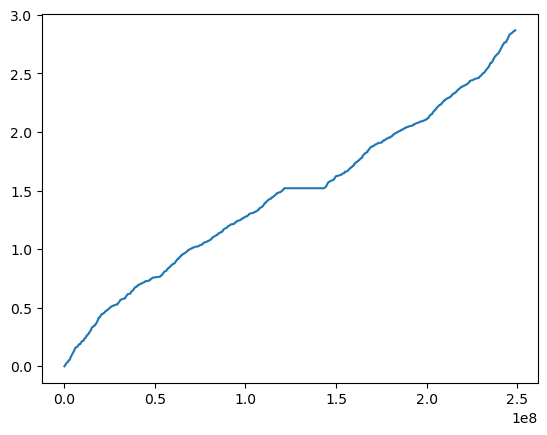

In [49]:
# first we load the HapMap lifted over to hg38
hm = RecMap('../data/annotation/hapmap_genetic_map.txt', 
            seqlens=hg38sl)

hmcr = hm.cum_rates['chr1']
plt.plot(hmcr.end, hmcr.rate)

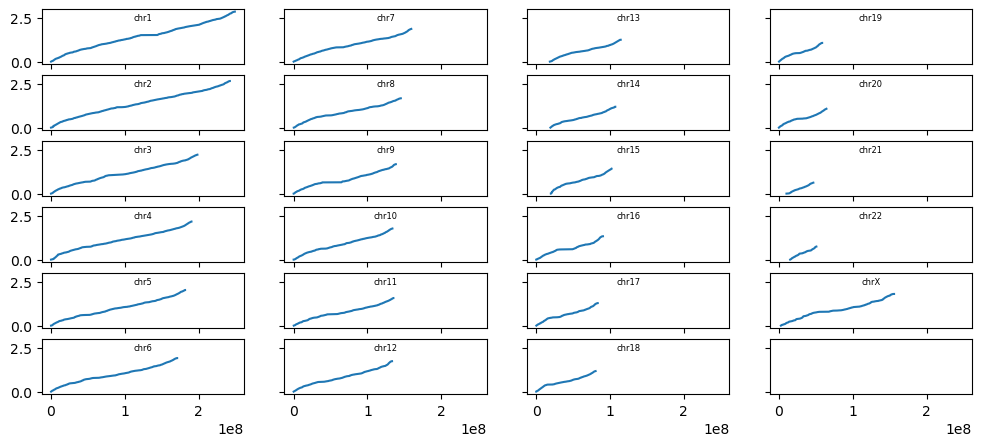

In [5]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    fax = ax[col, row]    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate)
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## Load in the raw previous liftover to hg37

Their data is already in a weird format (space separated, with lots of other data). See the `Snakefile` for the details on how this was processed.

In [133]:
d = pd.read_table('../data/annotation/aamap_hg37_raw.bed', sep='\t',
                  names=('chrom', 'end', 'rate'))
d.head()

,chrom,end,rate
0,chr1,82571,0.0
1,chr1,88169,0.0
2,chr1,564598,0.0
3,chr1,564621,0.0
4,chr1,565433,0.0


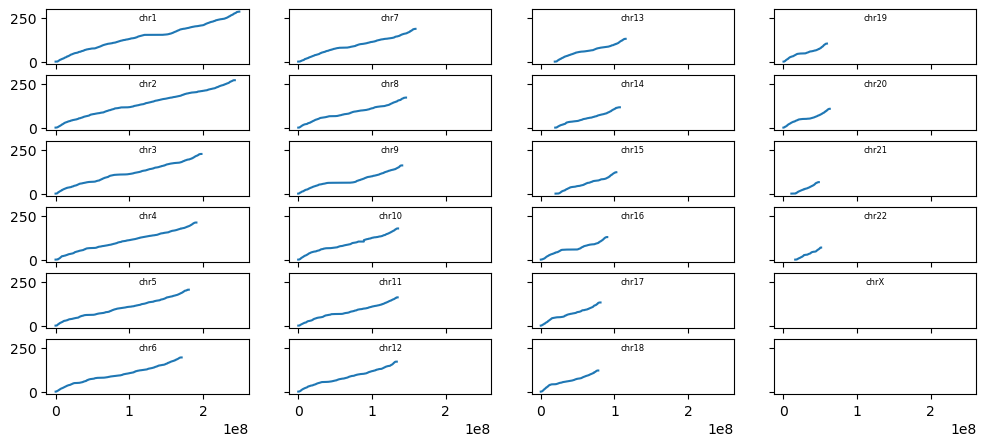

In [134]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    fax = ax[col, row]    
    dc = d.loc[d['chrom'] == chrom]
    fax.plot(dc['end'], dc['rate'])
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## Load in my liftover from hg37 to hg38

In [164]:
d = pd.read_table('../data/annotation/aamap_hg37_to_hg38_raw.bed', sep='\t',
                  names=('chrom', 'start', 'end', 'rate'))
d.head()

,chrom,start,end,rate
0,chr1,82571,88169,0.0
1,chr1,629218,629241,0.0
2,chr1,629241,630053,0.0
3,chr1,630053,632942,0.0
4,chr1,632942,633147,0.0


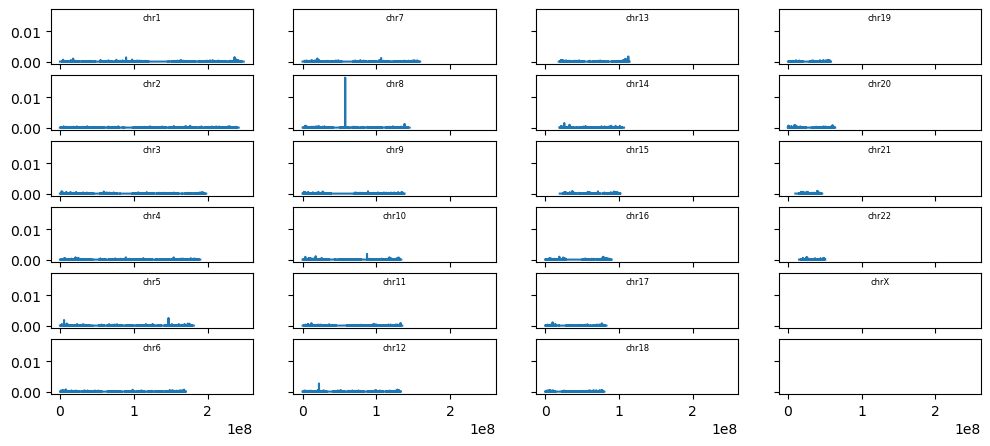

In [166]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    fax = ax[col, row]    
    dc = d.loc[d['chrom'] == chrom]
    fax.plot(dc['end'], dc['rate'])
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)
    #fax.set_ylim(0, 0.001)

## Filtering on Rates

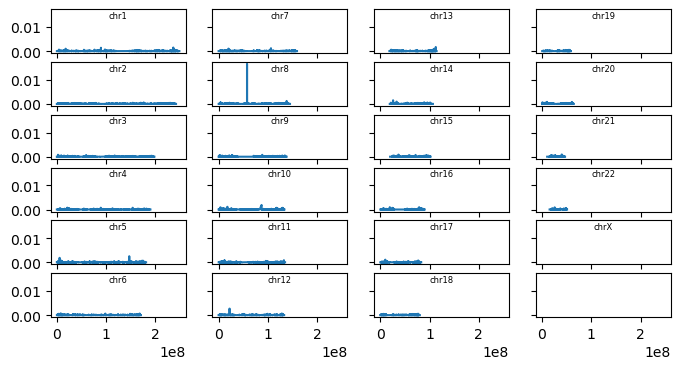

In [173]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(8, 4), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    fax = ax[col, row]
    fax.plot(0.5*(dc['start']+dc['end']), dc['rate'], label='raw Hinch et al. hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

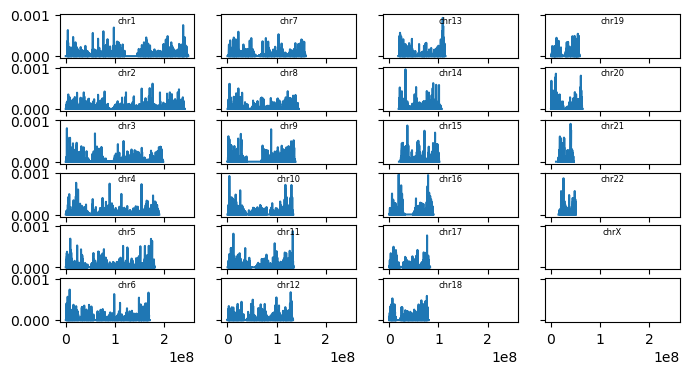

In [175]:
THRESH = 0.001
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(8, 4), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    fax = ax[col, row]
    fax.plot(0.5*(dc['start']+dc['end']), dc['rate'], label='raw Hinch et al. hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

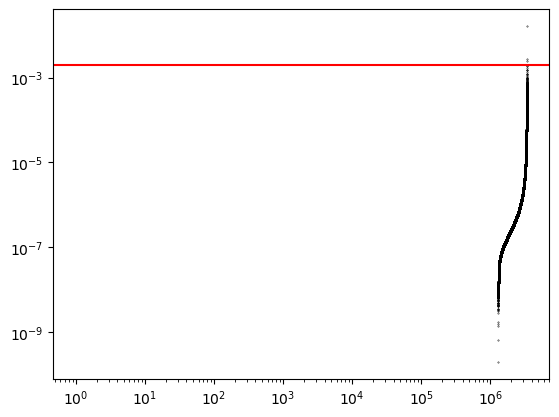

In [171]:
x = np.sort(d['rate'])
plt.scatter(np.arange(len(x)), x, s=0.1, c='k')
plt.loglog()
plt.axhline(THRESH, c='r')

/tmp/ipykernel_7391/2361572667.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(1e-8, 0)


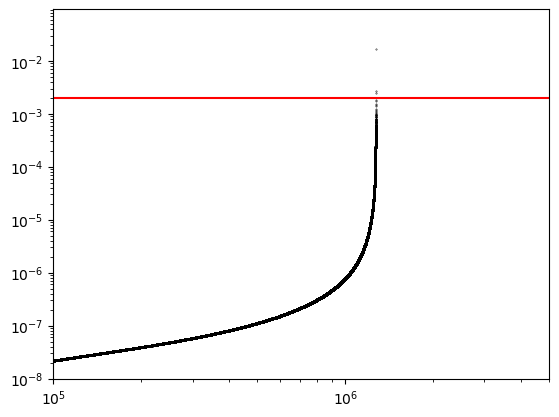

In [10]:
x = np.sort(d['rate'])
plt.scatter(np.arange(len(x)), x, s=0.1, c='k')
plt.loglog()
plt.xlim(1e5, 5e6)
plt.ylim(1e-8, 0)
plt.axhline(THRESH, c='r')

In [192]:
nchroms = list(range(1, 23))

def read(c):
    return pd.read_table(f"../data/annotation/maps_b37/maps_chr.{c}",
                         skiprows=1, sep=' ', 
                         names=('pos', 'rate'))

# hg36 hinch (no liftover)
raw_lo37 = {f"chr{c}": read(c) for c in nchroms}

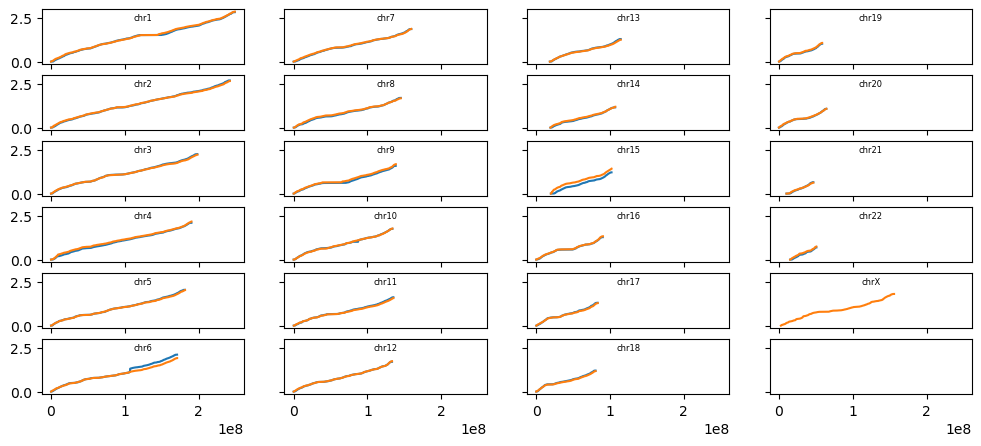

In [197]:
THRESH = 0.002
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc.sort_values(['start', 'end'])
    fax = ax[col, row]    
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='liftover Hinch hg38')
    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate)
    
    # if chrom in raw_lo37:
    #     dh = raw_lo37[chrom]
    #     x, y = dh['pos'], dh['rate']
    #     fax.plot(x, y)
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## The chromosome 6 outlier

You can see chr6 has one more issue we need to clean up

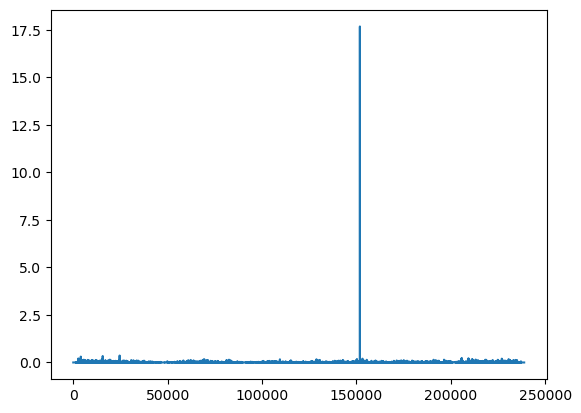

In [198]:
dc = d.loc[d['chrom'] == 'chr6']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
dc['cumm'] = np.cumsum(dc['dist'])

ydiff = dc['cumm'].diff().values
plt.plot(ydiff)

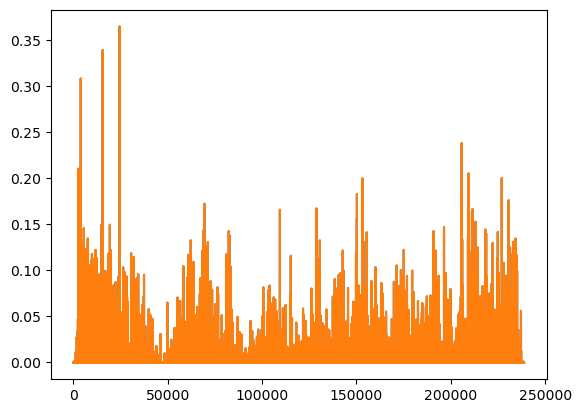

In [199]:
dc = d.loc[d['chrom'] == 'chr6']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
# the filter has to go here
dc = dc.loc[dc['dist'] < 2.5]
dc['cumm'] = np.cumsum(dc['dist'])

ydiff = dc['cumm'].diff().values
plt.plot(ydiff)
plt.plot(ydiff[ydiff < 2.5])

In [215]:
d = pd.read_table('../data/annotation/aamap_hg37_raw.tsv', names=('chrom', 'start', 'cumrate'))

In [216]:
next(iter(d.groupby('chrom')))

('chr1',
        chrom      start   cumrate
 0       chr1      82571    0.0000
 1       chr1      88169    0.0000
 2       chr1     564598    0.0000
 3       chr1     564621    0.0000
 4       chr1     565433    0.0000
 ...      ...        ...       ...
 268042  chr1  249209140  285.8845
 268043  chr1  249210707  285.8845
 268044  chr1  249211350  285.8845
 268045  chr1  249218281  285.8845
 268046  chr1  249218650  285.8845
 
 [268047 rows x 3 columns])

In [262]:
import tempfile
import subprocess

def read_cumulative(file):
    d = pd.read_table(file, names=('chrom', 'start', 'cumrate'))
    new_rates = dict()
    for chrom, df in d.groupby('chrom'):
        starts = df['start'].tolist()
        starts.insert(0, 0)
        cumrates = df['cumrate'].values
        # now we need to turn the cumulative rates into marginal rates between markers
        # for hapmap files, each row has the rate for that row's start and the next row's
        # start
        spans = np.diff(starts)
        rates = np.diff(cumrates) / spans[:-1]
        # why do we cut off the 0 we added, and the last position we lost in marginal
        # rates
        new_rates[chrom] = (np.array(starts[1:-1]).astype(int), np.array(rates))
    return new_rates

def write_hapmap(file, rates_dict, header=('chrom', 'position', 'rate')):
    with open(file, 'w') as f:
        if header:
            f.write('\t'.join(header) + '\n')
        for chrom, data in rates_dict.items():
            for s, r in zip(*data):
                f.write(f"{chrom}\t{s}\t{r}\n")
    
def write_bed(file, rates_dict):
    with open(file, 'w') as f:
        for chrom, data in rates_dict.items():
            pos, rates = data
            starts, ends = pos[:-1], pos[1:]
            rates = rates[:-1]
            for s, e, r in zip(starts, ends, rates):
                f.write(f"{chrom}\t{s}\t{e}\t{r}\n")
                
def read_bed(file):
    d = pd.read_table(file, names=('chrom', 'start', 'end', 'rate'))
    out = dict()
    for chrom, df in d.groupby('chrom'):
        starts, ends, rates = df.start.values, df.end.values, df.rate.values
        out[chrom] = (starts, ends, rates)
    return out

def run_liftover(oldmap, chain, minmatch=0.99):
    newmap = tempfile.NamedTemporaryFile().name
    unmap = oldmap.replace('.bed', '') + "_unmapped.bed"
    cmd = ["liftOver", f"-minMatch={minmatch}", oldmap, chain, newmap, unmap]
    subprocess.run(cmd)
    return read_bed(newmap)

def cumulative_rates(rate_dict):
    cumrates = dict()
    for chrom, rate in rate_dict.items():
        start
            
    
nr = read_cumulative('../data/annotation/aamap_hg37_raw.tsv')
write_bed('../data/annotation/test.bed', nr)

In [265]:
rr = run_liftover('../data/annotation/test.bed', "../data/annotation/hg19ToHg38.over.chain.gz")

Reading liftover chains
Mapping coordinates


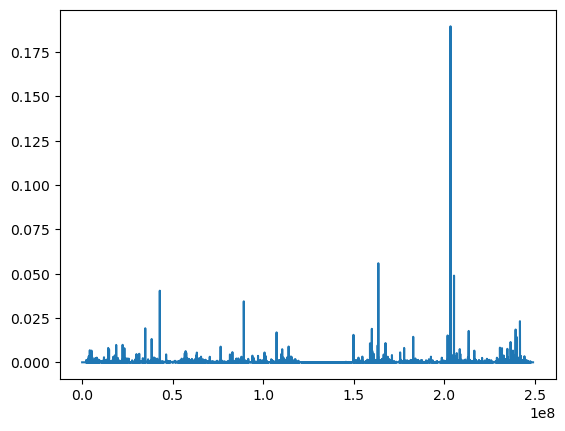

In [268]:
x, y = rr['chr1'][0], rr['chr1'][2]
plt.plot(x, y)

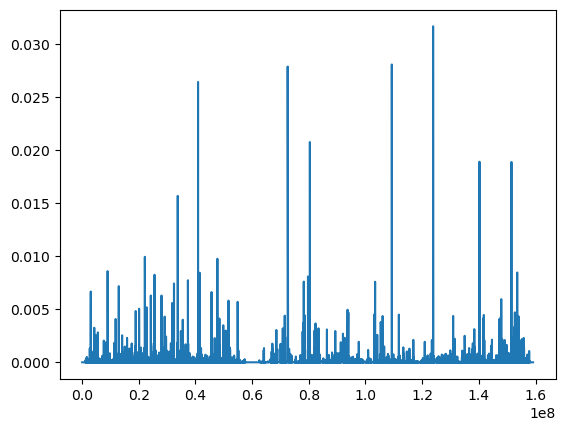

In [232]:
plt.plot(*nr['chr7'])

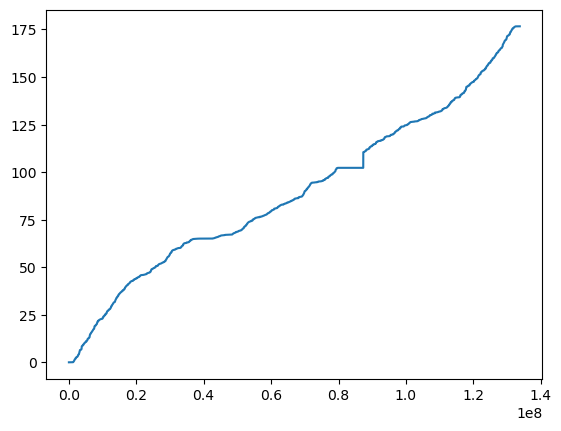

In [200]:
dc = d.loc[d['chrom'] == 'chr10']
dc = dc.sort_values(['start', 'end'])
dc['dist'] = dc['rate'] * (dc['end']-dc['start'])
dc['cumm'] = np.cumsum(dc['dist'])


plt.plot(dc['end'], dc['cumm'])

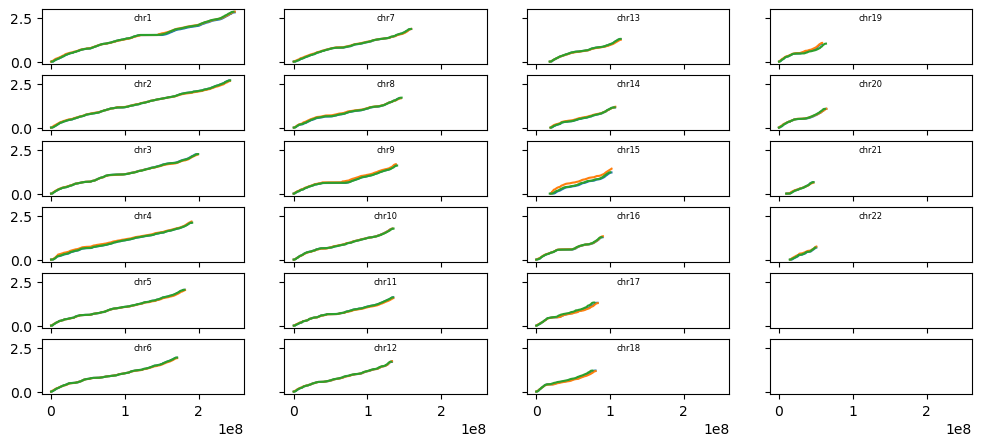

In [16]:
nc, nr = 4, 6

fig, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(12, 5), sharex=True, sharey=True)
entries = list(itertools.product(list(range(nc)), list(range(nr))))
for i, chrom in enumerate(chroms):
    row, col = entries[i]
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['end'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        dc = dc.loc[dc['rate'] * (dc['end']-dc['start']) < 2.5]
    
    #assert np.all(dc['end'].diff() > 0), chrom
    fax = ax[col, row]    
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='Hinch hg38 filtered')
    
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate, label='hapmap')
    
    if chrom in raw_hinsh:
        dh = raw_hinsh[chrom]
        x, y = dh['pos'], dh['rate']
        fax.plot(x, y/100, label='Hinch hg36')
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

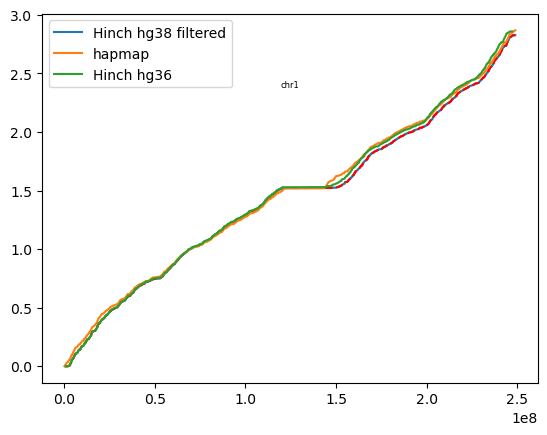

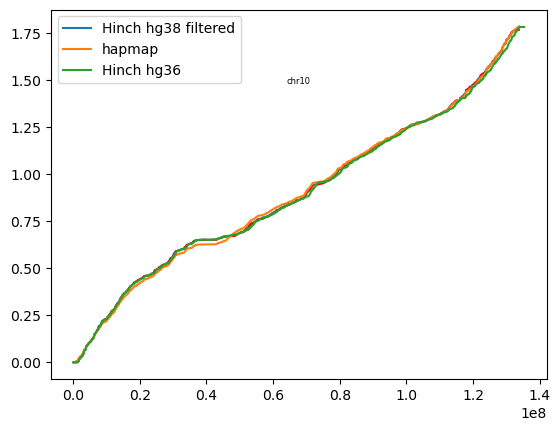

In [24]:
for i, chrom in enumerate(['chr1', 'chr10']):
    fig, fax = plt.subplots()

    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['end'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        dc = dc.loc[dc['rate'] * (dc['end']-dc['start']) < 2.5]
    
    # the filtered set
    fax.plot(dc['end'], 1/100 * np.cumsum(dc['rate'] * (dc['end']-dc['start'])), label='Hinch hg38 filtered')
    
    # now, we try to reconstruct the filtered set, from cumulative to rates
    # then make a cumulative map from this, and plot to compare —— should match
    # if we're doing this right
    ends = dc['end'].values
    starts = dc['start'].values
    span = ends - starts
    y = 1/100 * np.cumsum(dc['rate'] * span)
    rr = np.diff(y)
    plt.plot(ends[:-1], np.cumsum(rr), c='r', linestyle='dashed')
    
    # now, we do another check, that if we put in the rates 
    # in a RateMap, that the cumulative mass from that also lines up
    new_rates = list(rr)
    new_ends = list(ends[:-1])
    new_ends.insert(0, 0)
    new_rates.insert(0, np.nan)
    new_ends.append(hg38sl[chrom])
    new_ends, new_rates = np.array(new_ends), np.array(new_rates) / np.diff(new_ends)
    tr = tsk.RateMap(position=new_ends, rate=new_rates)
    #fax.plot(tr.position, tr.get_cumulative_mass(tr.position), c='k')
    
    # the hapmap set
    hmcr = hm.cum_rates[chrom]
    fax.plot(hmcr.end, hmcr.rate, label="hapmap")
    
    # raw hinch
    if chrom in raw_hinsh:
        dh = raw_hinsh[chrom]
        x, y = dh['pos'], dh['rate']
        fax.plot(x, y/100, label="Hinch hg36")
    fax.legend()
    fax.text(0.5, 0.8, chrom, fontsize=6, 
             horizontalalignment='center',
             transform=fax.transAxes)

## Summary

 - Special filtering of chr6
 - General outlier filtering
 - Recompute-cummulative map, and from this, recompute marginal rates.

The following code is used in the snakemake pipeline.

## Validation

### Check all in Order

In [36]:
fixed = []
rms = dict()
for chrom in chroms:
    dc = d.loc[d['chrom'] == chrom]
    dc = dc[dc['rate'] < THRESH]
    dc = dc.sort_values(['end'])
    
    if chrom == 'chr6':
        # filter out the chr6 outlier
        dc = dc.loc[dc['rate'] * (dc['end']-dc['start']) < 2.5]
    
    dc = d.loc[d['chrom'] == chrom]
    
    # build rate map -- NOTE there is a minor error here, 
    # in the way this is built, suspected off-by one. But see the 
    # snakemake file, which is correct
    rms[chrom] = tsk.RateMap(position=[0] + dc['end'].tolist(), rate=dc['rate'])
    fixed.append(dc)
    print(chrom, (dc['end'].diff() <= 0).sum())

chr1 0
chr2 0
chr3 0
chr4 0
chr5 0
chr6 0
chr7 0
chr8 0
chr9 0
chr10 0
chr11 0
chr12 0
chr13 0
chr14 0
chr15 0
chr16 0
chr17 0
chr18 0
chr19 0
chr20 0
chr21 0
chr22 0


### Snakemake Output and RecMap Object Validation

Now, let's analyze the results **as they come out of snakemake**.

In [51]:
rm = RecMap('../data/annotation/aamap_hg38.tsv', 
            seqlens=hg38sl)

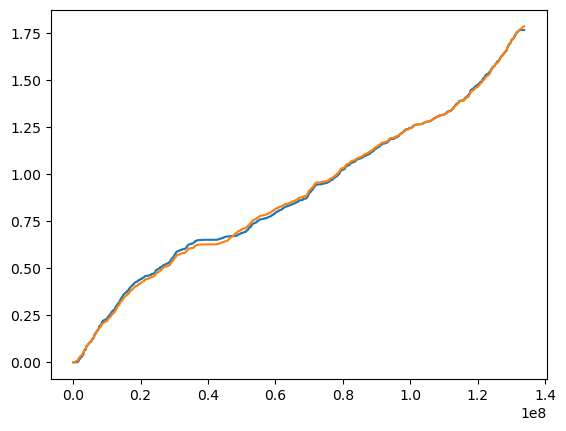

In [38]:
plt.plot(*rm.cum_rates['chr10'])
hmcr = hm.cum_rates['chr10']
plt.plot(hmcr.end, hmcr.rate)

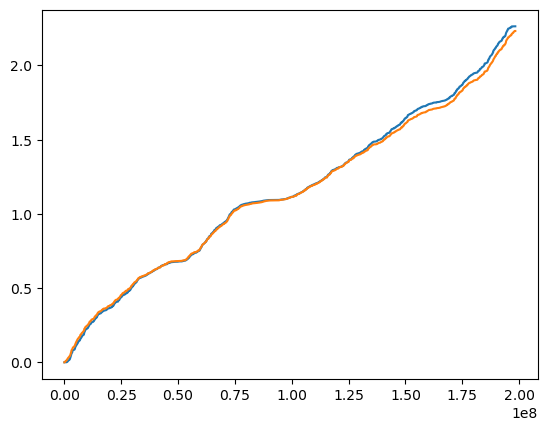

In [52]:
plt.plot(*rm.cum_rates['chr3'])
hmcr = hm.cum_rates['chr3']
plt.plot(hmcr.end, hmcr.rate)

In [55]:
np.mean((y- y_aa)**2)

0.0

In [56]:
hm

RecMap('../data/annotation/hapmap_genetic_map.txt')
 total length: 37.31 Morgans

In [59]:
hm.rates['chr1']

RecPair(end=array([    55550,     82571,     88169, ..., 248924451, 248924793,
       248956422]), rate=array([0.000000e+00, 2.981822e-08, 2.082414e-08, ..., 7.844430e-09,
       7.094450e-09, 0.000000e+00]))

In [58]:
rm.rates['chr1']

RecPair(end=array([   818802,    825532,    833068, ..., 248916508, 248917151,
       248956422]), rate=array([0.00000000e+00, 4.80027956e-14, 5.32972672e-14, ...,
       4.85513919e-14, 4.67191518e-14, 1.02785658e-14]))

[]

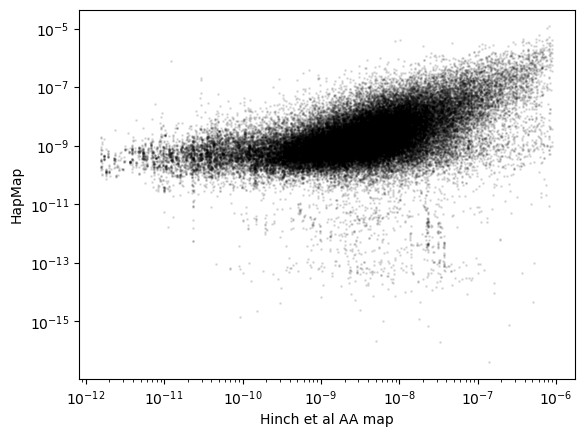

In [66]:
x, y_aa = rm.rates['chr7']
#plt.plot(x, y_aa)
hmrs = hm.lookup('chr7', x)
plt.scatter(hmrs, y_aa, s=1, c='k', alpha=0.1)
plt.xlabel('Hinch et al AA map')
plt.ylabel('HapMap')
plt.loglog()

In [90]:
rh_pos, rh_cum = raw_hinsh['chr7']['pos'], raw_hinsh['chr7']['rate']

y = np.diff(rh_cum) / np.diff(rh_pos)
x = rh_pos[1:]

[]

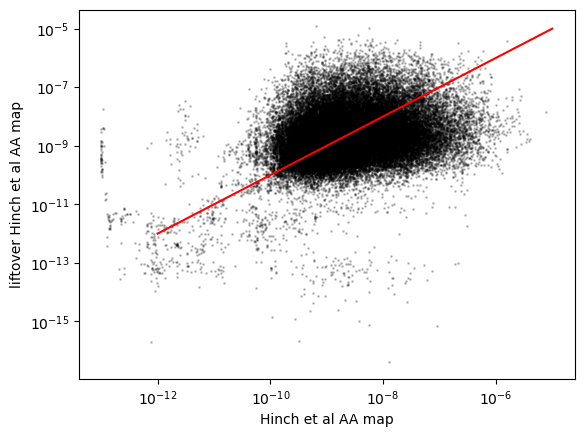

In [91]:
#plt.plot(x, y_aa)
rmrs = rm.lookup('chr7', x) 
plt.scatter(rmrs, y/100, s=1, c='k', alpha=0.2)
plt.xlabel('Hinch et al AA map')
plt.ylabel('liftover Hinch et al AA map')
xx = np.linspace(1e-12, 1e-5, 100)
plt.plot(xx, xx, c='r')
plt.loglog()

In [97]:
bm = RecMap('../data/annotation/aamap_back_to_hg18.tsv',
            seqlens=load_seqlens('../data/annotation/hg18_seqlens.tsv'))

[]

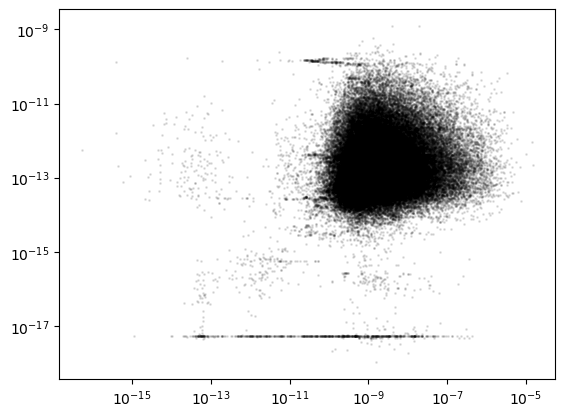

In [102]:
x, y_lift = rm.rates['chr1']
y_back = bm.lookup('chr1', x)
plt.scatter(y_lift, 100*y_back, s=1, c='k', alpha=0.1)
plt.loglog()

### All Validation Plots

/tmp/ipykernel_7391/1502298626.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, fax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)


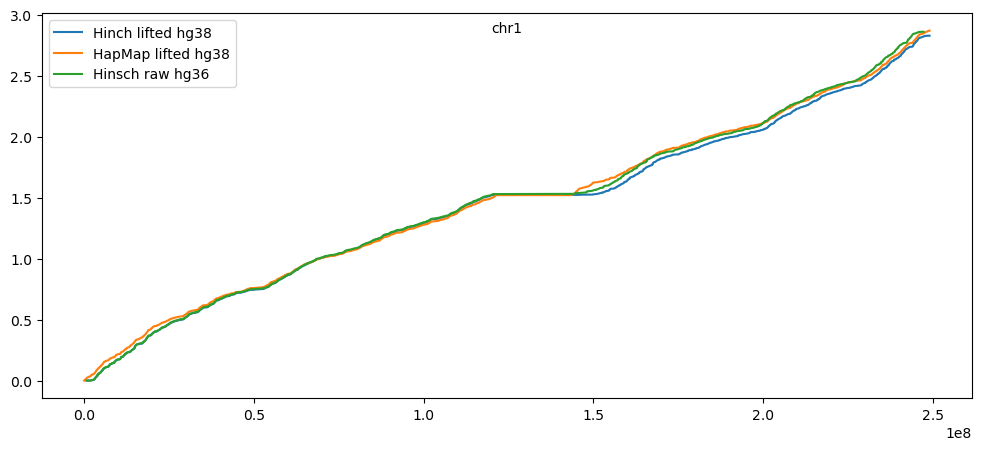

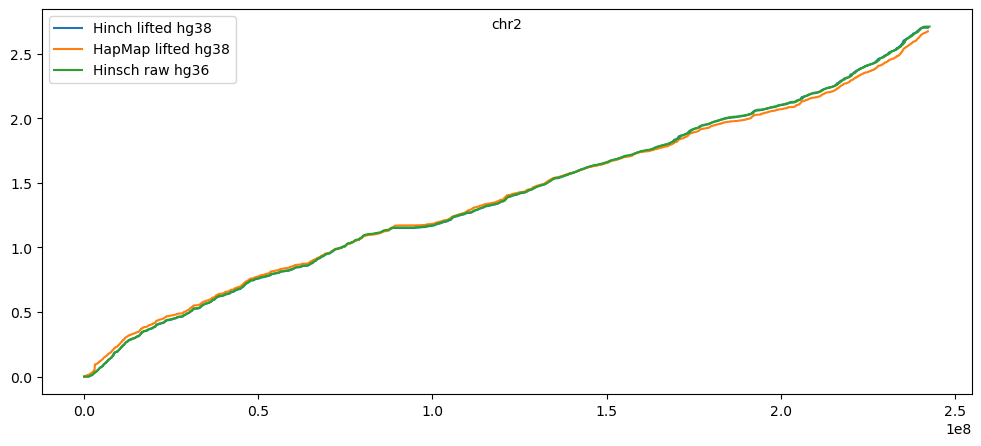

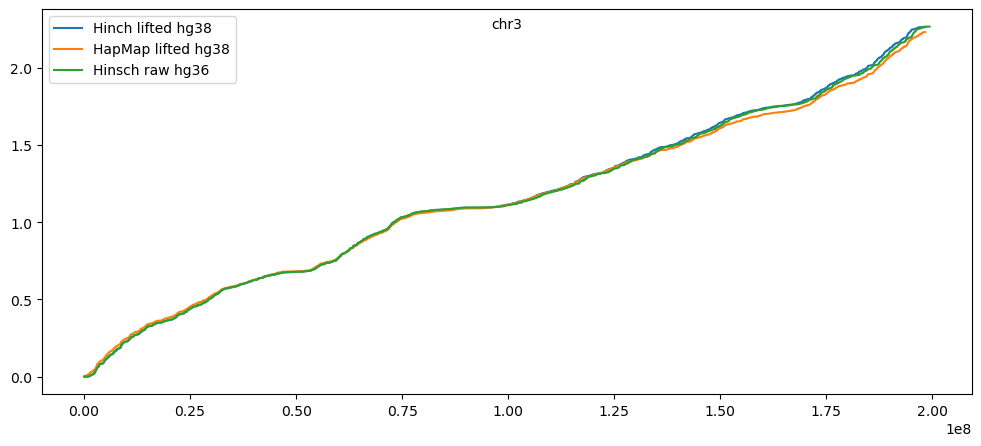

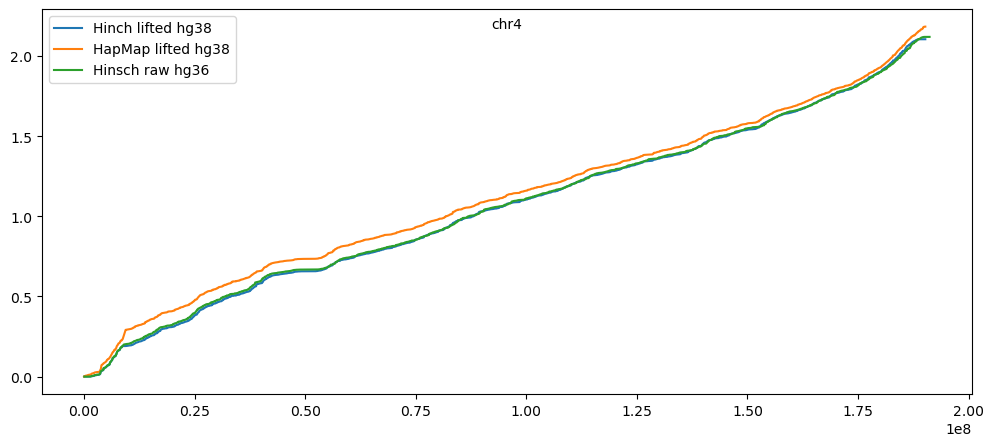

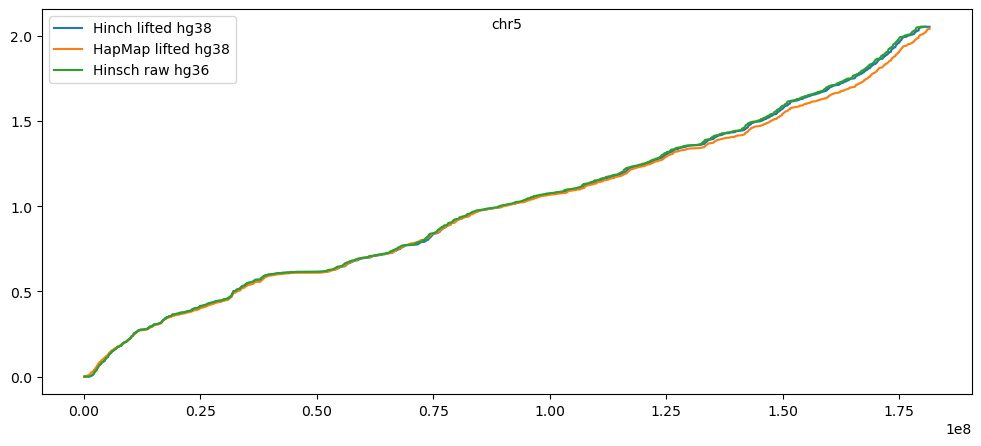

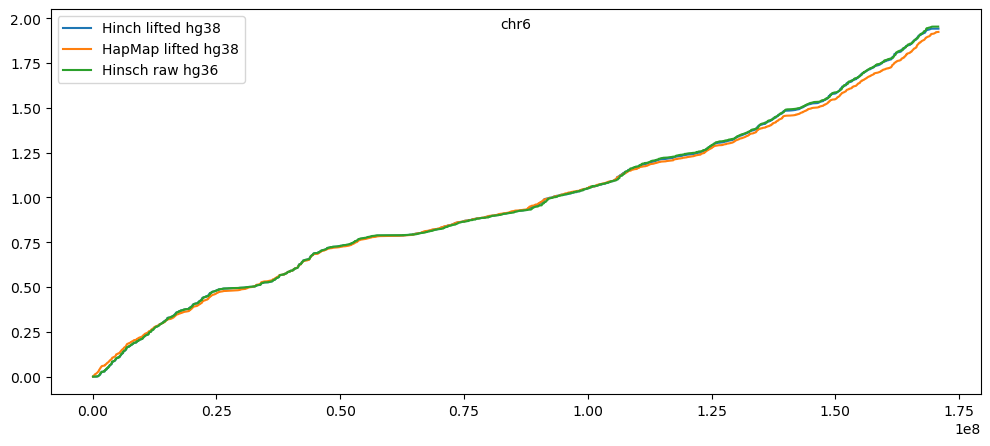

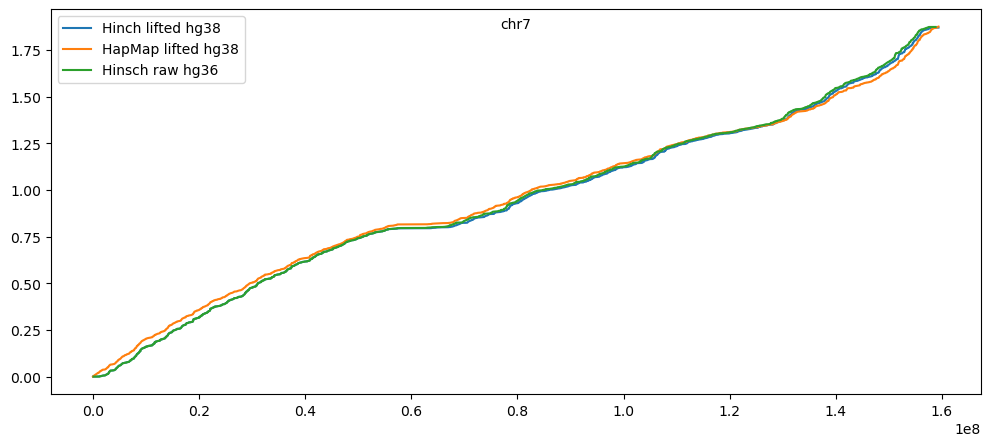

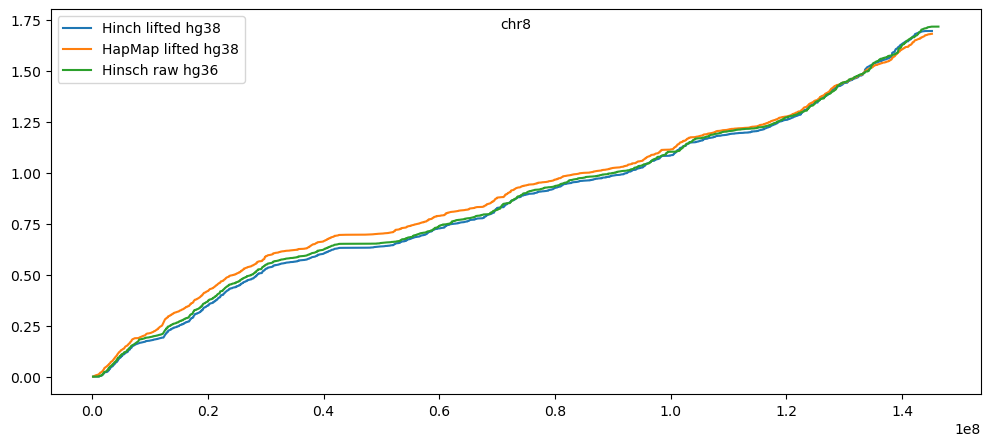

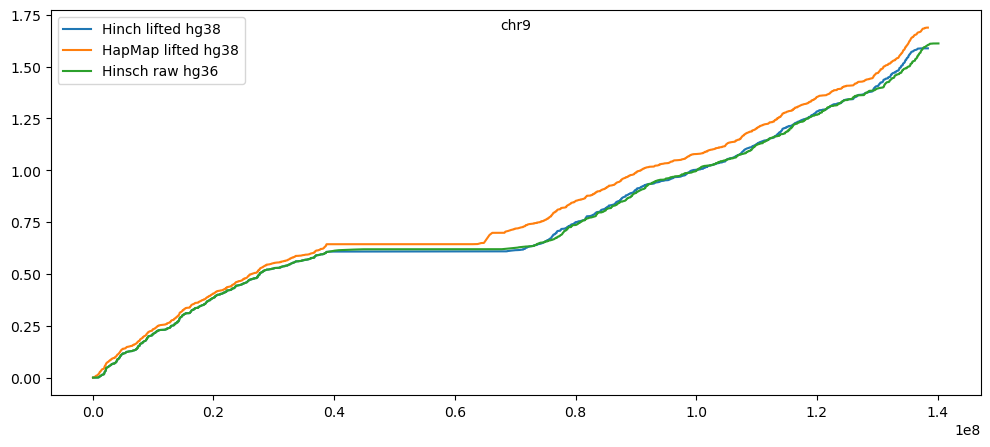

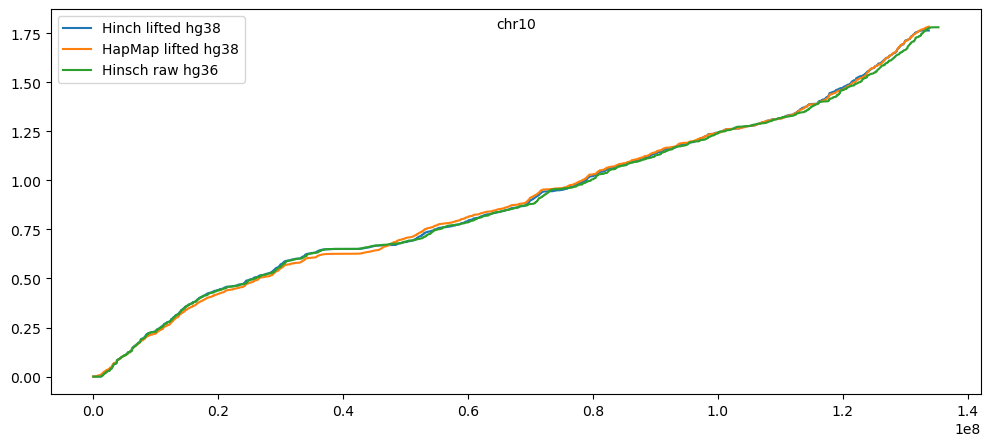

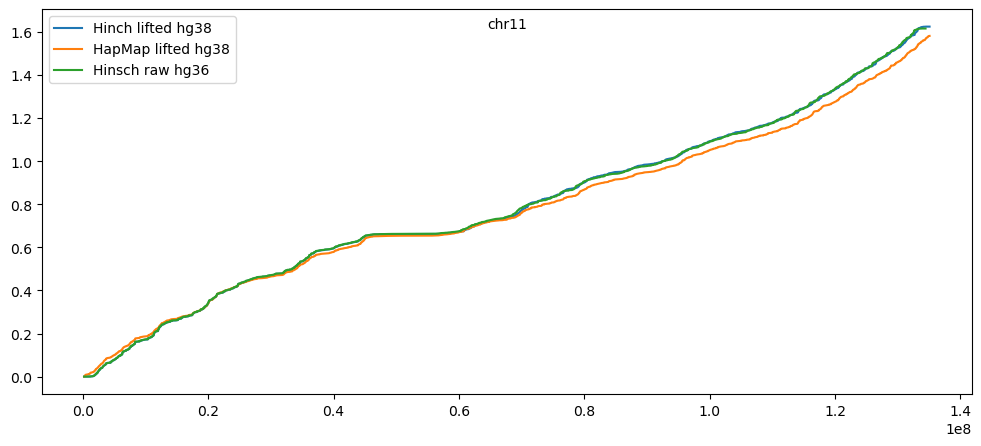

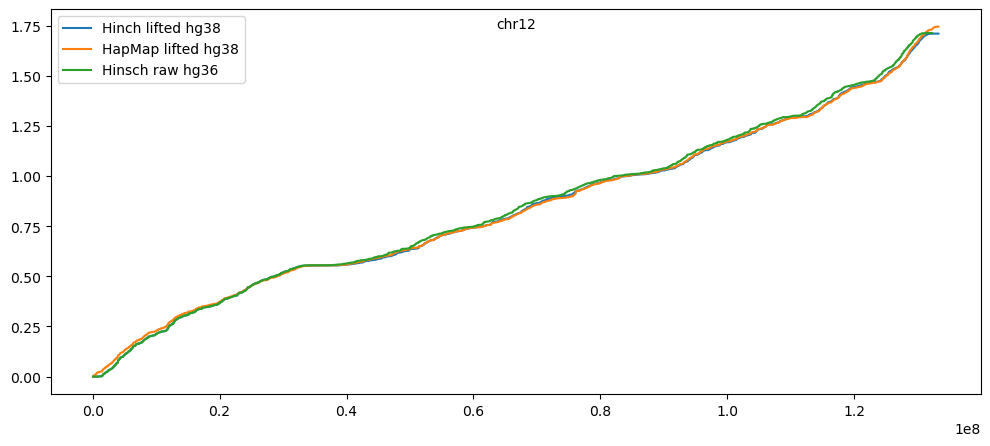

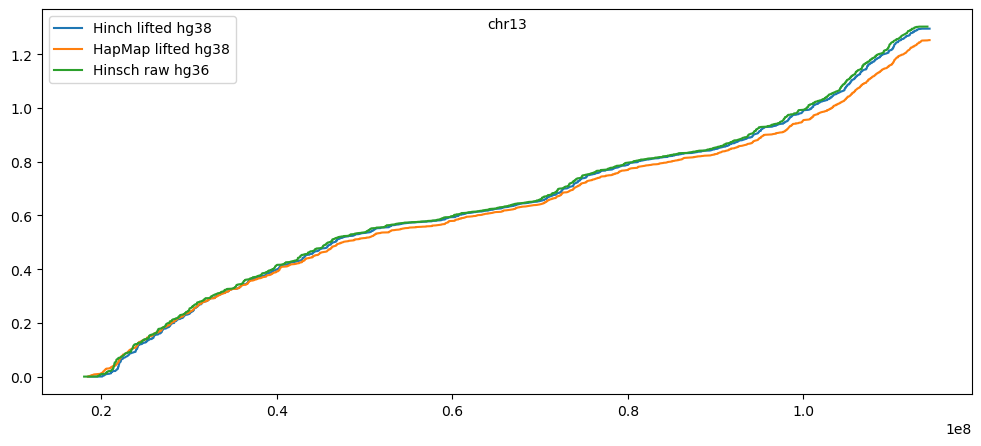

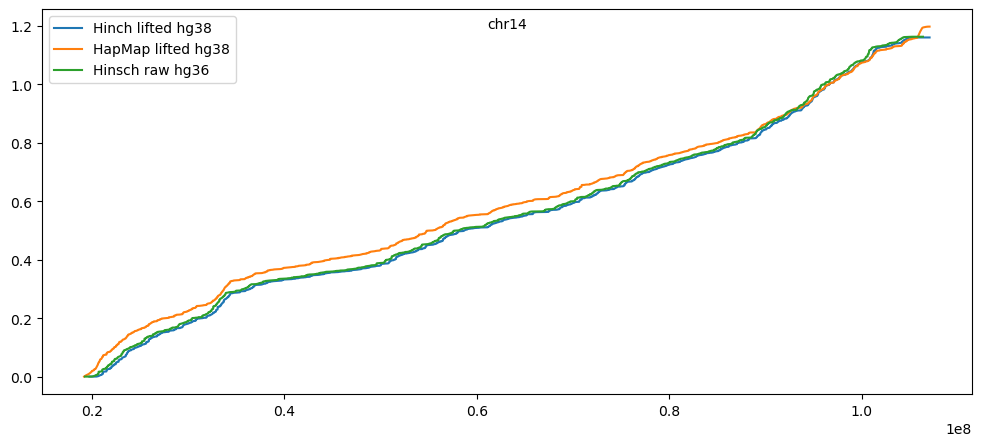

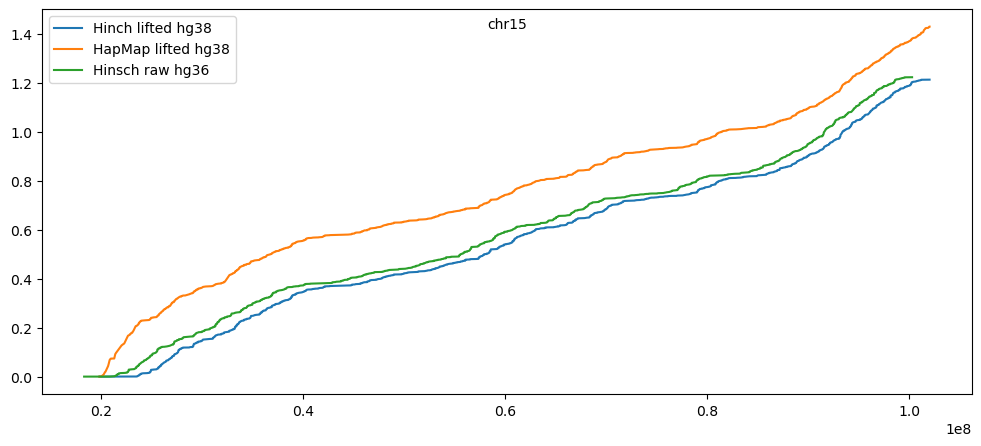

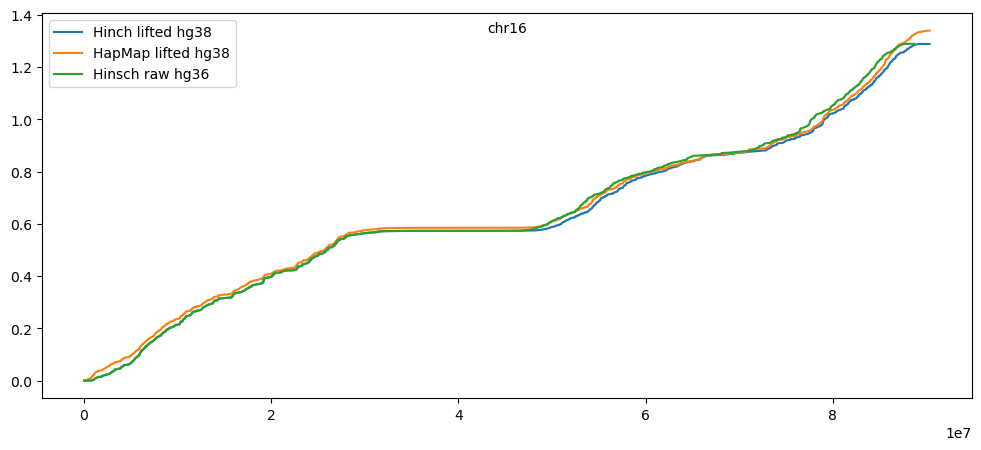

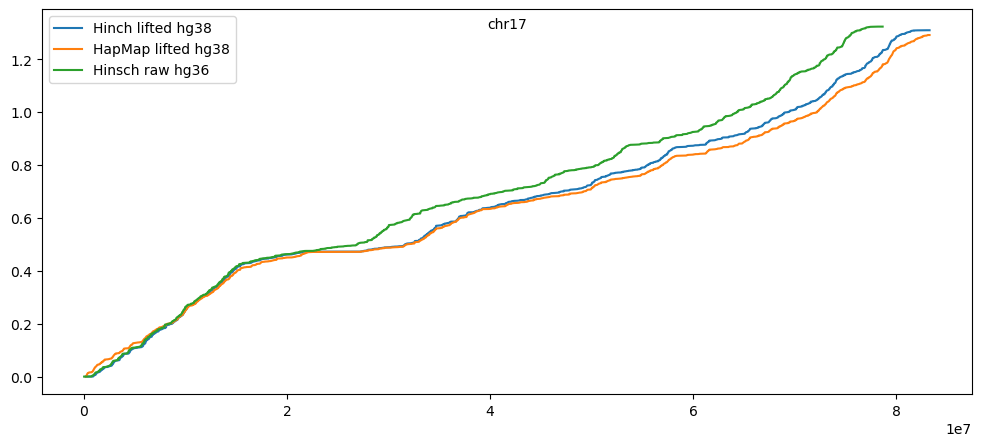

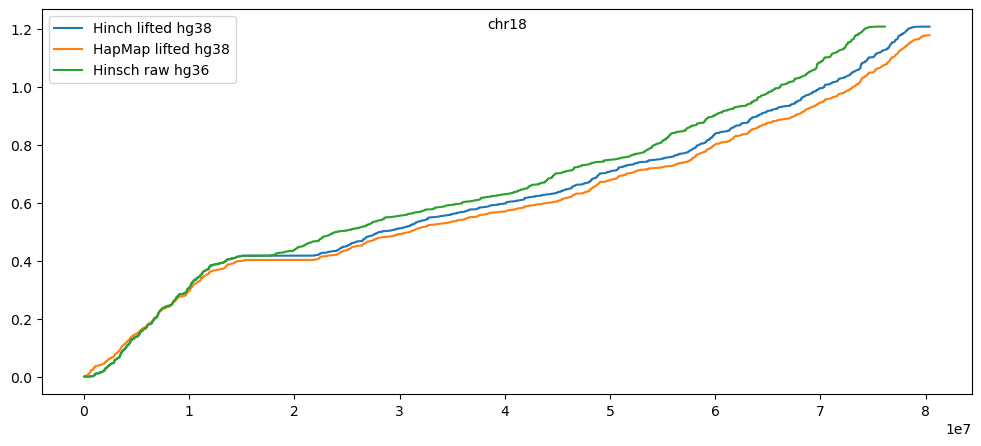

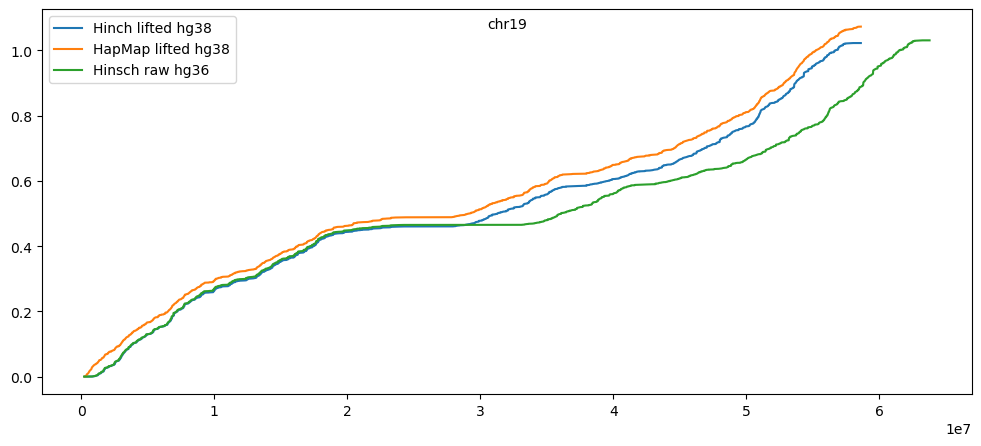

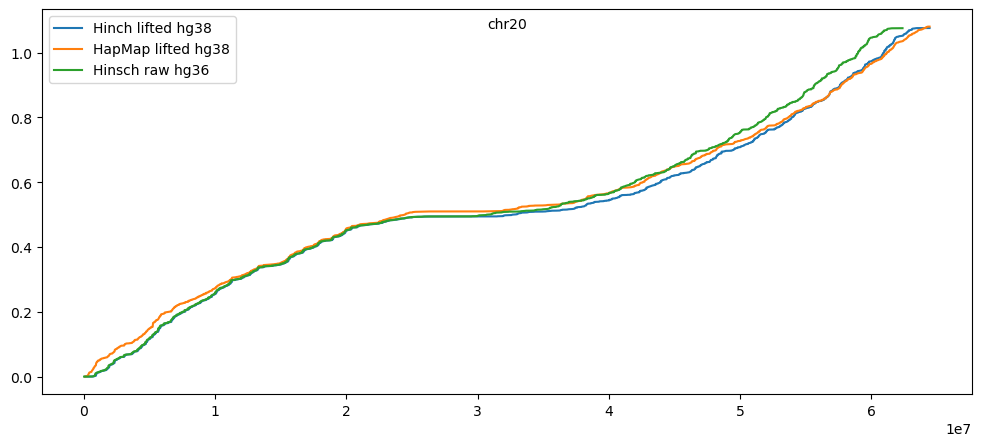

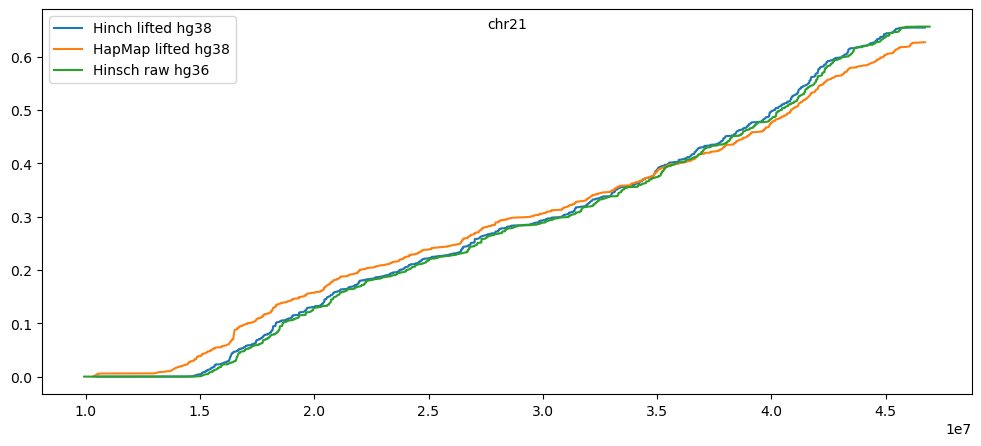

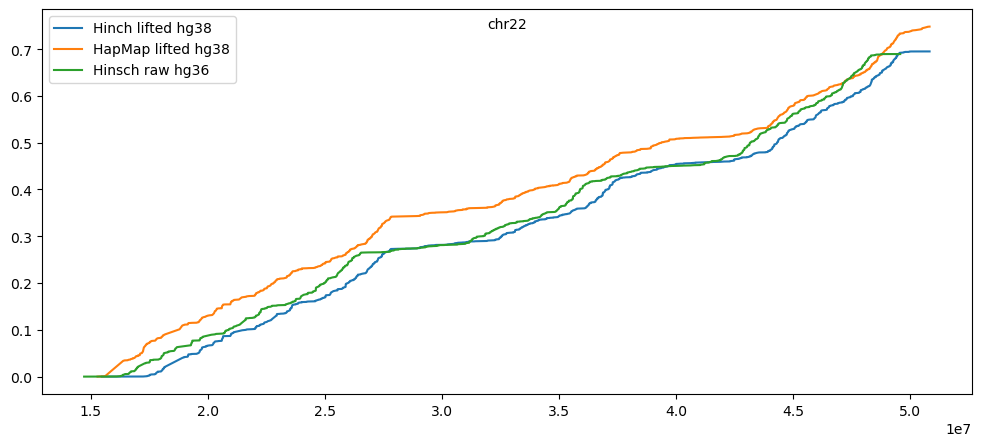

In [22]:
for i, chrom in enumerate(chroms):
    fig, fax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)
    row, col = entries[i]
    #dc = dfixed.loc[dfixed['chrom'] == chrom]
    
    #fax.plot(dc['end'], dc['cum'], label='fixed Hinch et al. hg38')
    x, y = rm.cum_rates[chrom]
    fax.plot(x, y, label='Hinch lifted hg38')
    
    x, y = hm.cum_rates[chrom]
    fax.plot(x, y, label='HapMap lifted hg38')
    
    if chrom in raw_hinsh:
        dh = raw_hinsh[chrom]
        x, y = dh['pos'], dh['rate']
        fax.plot(x, y/100, label='Hinsch raw hg36')
    
    fax.text(0.5, 0.95, chrom, fontsize=10, 
             horizontalalignment='center',
             transform=fax.transAxes)
    fax.legend()